## 月別気候値

30年間分の月平均データを読み，NetCDF形式で保存する。30年間の平均を計算し，気候値（平年の値）とする。これもNetCDF形式で保存する。

### 長期月平均データ

先ほど作成したHadISSTテキストデータを読む関数の名前を`readtext()`に変更し，`hadisst1.py`という名前で保存する。このスクリプトの中で経度と緯度を計算する。

In [1]:
import re
import numpy as np
import numpy.ma as ma

nx = 360; ny = 180
lon = -179.5 + np.arange(nx)
lat = 89.5 - np.arange(ny)

def readtxt(fname, m):
    fin = open(fname, 'rt')
    sst = ma.zeros((m, ny, nx))
    land = -32768
    seaice = -1000
    for k in range(m):
        fin.readline()
        for j in range(ny):
            line = re.sub(str(land), ' '+str(seaice), fin.readline())
            sst[k, j, :] = ma.masked_equal(np.array(line.split()).astype(int), seaice) * 0.01
    fin.close()
    return sst

保存したスクリプトはモジュールとして`import`できる。

In [2]:
import hadisst1

HadISST1の[ダウンロードページ](http://www.metoffice.gov.uk/hadobs/hadisst/data/download.html)から`HadISST1_SST_1961-1990.txt.gz`をダウンロードして解凍する。

In [3]:
sst_mon = hadisst1.readtxt('HadISST1_SST_1961-1990.txt', 30 * 12)
sst_mon.shape

(360, 180, 360)

年と月別の次元に分ける。

In [4]:
sst_year_mon = sst_mon.reshape(30, 12, 180, 360)
sst_year_mon.shape

(30, 12, 180, 360)

扱いやすいNetCDF形式で保存しておこう。

In [5]:
import netCDF4
import hadisst1
nc = netCDF4.Dataset('HadISST1_SST_1961-1990.nc', 'w')
nc.createDimension('time', None)
nc.createDimension('lat', hadisst1.ny)
nc.createDimension('lon', hadisst1.nx)

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 360

In [6]:
import numpy as np
time = nc.createVariable('time', 'i', ('time'))
time.long_name = 'time'
time.units = 'months since 1961-01-15 00:00:00'
time[:] = np.arange(sst_mon.shape[0])

In [7]:
lat = nc.createVariable('lat', 'f', ('lat'))
lat.long_name = 'latitude'
lat.units = 'degrees north'
lat[:] = hadisst1.lat

In [8]:
lon = nc.createVariable('lon', 'f', ('lon'))
lon.long_name = 'longitude'
lon.units = 'degrees east'
lon[:] = hadisst1.lon

In [9]:
sst = nc.createVariable('sst', 'f', ('time', 'lat', 'lon'))
sst.long_name = 'sea-surface temperature'
sst.units = 'degC'
sst[:,:,:] = sst_mon

In [10]:
nc.close()

### 気候値の作成

各月について年の次元（`axis=0`）について平均（`mean`）を計算する。

In [11]:
import numpy.ma as ma
sst_mon_clim = ma.empty((12, hadisst1.ny, hadisst1.nx))
for k in range(12):
    sst_mon_clim[k,:,:] = sst_year_mon[:,k,:,:].mean(axis=0)

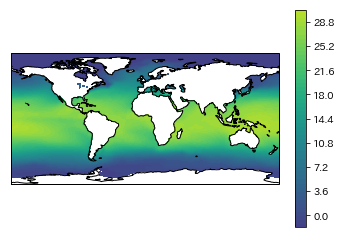

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import hadisst1

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(hadisst1.lon, hadisst1.lat, sst_mon_clim[0,:,:], 60, transform=ccrs.PlateCarree(), vmin = -10.0, vmax = 35.0)
plt.colorbar()

ax.coastlines()

plt.show()

1990年1月の海面水温偏差を描画する。

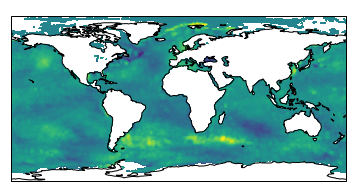

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import hadisst1

ax = plt.axes(projection=ccrs.PlateCarree())

year = 1990
dsst = sst_year_mon[-1, 0, :, :] - sst_mon_clim[0,:,:]
plt.contourf(hadisst1.lon, hadisst1.lat, dsst, 60, transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

気候値もNetCDFで保存する。

In [14]:
import netCDF4
import hadisst1
nc = netCDF4.Dataset('HadISST1_SST_1961-1990_clim.nc', 'w')
nc.createDimension('time', None)
nc.createDimension('lat', hadisst1.ny)
nc.createDimension('lon', hadisst1.nx)

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 360

In [15]:
import numpy as np
time = nc.createVariable('time', 'i', ('time'))
time.long_name = 'time'
time.units = 'months since 0001-01-15 00:00:00'
time[:] = np.arange(sst_mon_clim.shape[0])

In [16]:
lon = nc.createVariable('lon', 'f', ('lon'))
lon.long_name = 'longitude'
lon.units = 'degrees east'
lon[:] = hadisst1.lon

In [17]:
sst = nc.createVariable('sst', 'f', ('time', 'lat', 'lon'))
sst.long_name = 'sea-surface temperature'
sst.units = 'degC'
sst[:,:,:] = sst_mon_clim

In [18]:
nc.close()